In [82]:
import stackstac
import pystac
import pystac_client
import numpy as np
import geopandas as gpd
from datetime import datetime
import os
from dask.distributed import Client
import dask.diagnostics
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt

In [83]:
start_time = '2019-12-01'
end_time = '2020-08-01'
time_slice = slice(start_time,end_time)
bounding_box_gf=gpd.read_file('shapefiles/grandmesa.geojson')
cloud_cover_threshold = 20

In [84]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

In [85]:
# Paste /proxy/localhost:8787 for cluster diagnostics
client = Client(local_directory='/tmp', processes=False)

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37989 instead
  warnings.warn(


In [86]:
lower_lon, upper_lat, upper_lon, lower_lat = bounding_box_gf.bounds.values[0]
lon = (lower_lon + upper_lon)/2
lat = (lower_lat + upper_lat)/2

In [87]:
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

In [88]:
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime=f"{start_time}/{end_time}"
).get_all_items()

In [89]:
#string = f'{ts_ds.rio.crs}'
#epsg_code = int(string[5:])
epsg_code=32613
stack = stackstac.stack(items, epsg=epsg_code)

In [90]:
stack

<xarray.DataArray 'stackstac-e97ba38e5be4a37bbc17dc372523ced2' (time: 100,
                                                                band: 17,
                                                                y: 11684,
                                                                x: 13135)>
dask.array<fetch_raster_window, shape=(100, 17, 11684, 13135), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                        (time) datetime64[ns] 2020-03-30T18:13:10 ......
    id                          (time) <U24 'S2A_12SYJ_20200330_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 1.784e+05 1.784e+05 ... 3.098e+05
  * y                           (y) float64 4.404e+06 4.404e+06 ... 4.287e+06
    sentinel:grid_square        (time) <U2 'YJ' 'BD' 'YJ' ... 'YJ' 'YJ' 'BD'
    ...                          ...
    updated                     (time) <U24 '2020-08-19T20:13:17.217Z' ... '2...
    view:off_nadir              int64 0
    sentinel:product_id         (time) <U60 'S2A_MSIL2A_20200330T175921_N0214...
    data_coverage               (time) object None None 46.49 ... None None None
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(178430.0, 4287030.0, 309780.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 178430.00|\n| 0.00,-10.00, 4403870.00|\n| 0.0...
    resolution:  10.0

In [91]:
if np.unique(stack['proj:epsg']).size>1:
    stack = stack[stack['proj:epsg']!=stack['epsg']]

In [92]:
stack

<xarray.DataArray 'stackstac-e97ba38e5be4a37bbc17dc372523ced2' (time: 51,
                                                                band: 17,
                                                                y: 11684,
                                                                x: 13135)>
dask.array<getitem, shape=(51, 17, 11684, 13135), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                        (time) datetime64[ns] 2020-03-30T18:13:10 ......
    id                          (time) <U24 'S2A_12SYJ_20200330_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 1.784e+05 1.784e+05 ... 3.098e+05
  * y                           (y) float64 4.404e+06 4.404e+06 ... 4.287e+06
    sentinel:grid_square        (time) <U2 'YJ' 'YJ' 'YJ' ... 'YJ' 'YJ' 'YJ'
    ...                          ...
    updated                     (time) <U24 '2020-08-19T20:13:17.217Z' ... '2...
    view:off_nadir              int64 0
    sentinel:product_id         (time) <U60 'S2A_MSIL2A_20200330T175921_N0214...
    data_coverage               (time) object None 46.49 None ... None None None
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(178430.0, 4287030.0, 309780.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 178430.00|\n| 0.00,-10.00, 4403870.00|\n| 0.0...
    resolution:  10.0

In [93]:
# import bounding box
bounding_box_utm_gf = bounding_box_gf.to_crs(stack.crs)
xmin, ymax, xmax, ymin = bounding_box_utm_gf.bounds.values[0]
#rainier_glaciers = rainier_glaciers.to_crs(stack.crs)

In [94]:
lowcloud = stack[stack["eo:cloud_cover"] < cloud_cover_threshold]
t = np.datetime64('2020-05-05T19:21:34.000000000')
lowcloud = lowcloud.loc[lowcloud.time !=t]
#stack.sel(time=time_slice) 298 images for the year
#lowcloud.sel(time=time_slice) 87 lowcloud days for the year

In [95]:
# could resample at the end in order to get more pixelwise values
if 'resample_freq' in locals():
    lowcloud = lowcloud.resample(time=resample_freq).median("time", keep_attrs=True)
#   resampled = lowcloud.resample(time=resample_freq).mean("time", keep_attrs=True)
else:
    lowcloud = lowcloud

In [96]:
lowcloud

<xarray.DataArray 'stackstac-e97ba38e5be4a37bbc17dc372523ced2' (time: 23,
                                                                band: 17,
                                                                y: 11684,
                                                                x: 13135)>
dask.array<getitem, shape=(23, 17, 11684, 13135), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                        (time) datetime64[ns] 2020-04-06T18:03:14 ......
    id                          (time) <U24 'S2A_12SYJ_20200406_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 1.784e+05 1.784e+05 ... 3.098e+05
  * y                           (y) float64 4.404e+06 4.404e+06 ... 4.287e+06
    sentinel:grid_square        (time) <U2 'YJ' 'YJ' 'YJ' ... 'YJ' 'YJ' 'YJ'
    ...                          ...
    updated                     (time) <U24 '2020-09-19T01:27:25.874Z' ... '2...
    view:off_nadir              int64 0
    sentinel:product_id         (time) <U60 'S2A_MSIL2A_20200406T174901_N0214...
    data_coverage               (time) object 46.21 None None ... None None None
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(178430.0, 4287030.0, 309780.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 178430.00|\n| 0.00,-10.00, 4403870.00|\n| 0.0...
    resolution:  10.0

In [97]:
# select bands
rgb = lowcloud.sel(band=["B04","B03","B02"])

nir, red, vir, swir = lowcloud.sel(band="B08"), lowcloud.sel(band="B04"), lowcloud.sel(band="B03"), lowcloud.sel(band="B11")
# NDVI is (B8-B4)/(B8+B4) https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
ndvi = (nir-red)/(nir+red)
# NDSI is (B3-B11)/(B3+B11) https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
ndsi = (vir-swir)/(vir+swir)


# SCL classifications https://www.sentinel-hub.com/faq/how-get-s2a-scene-classification-sentinel-2/
scl = lowcloud.sel(band="SCL")
# look at preciptable water vapor? maybe something telling about melt / evaporation
wvp = lowcloud.sel(band="WVP")

In [98]:
ndsi

<xarray.DataArray 'stackstac-e97ba38e5be4a37bbc17dc372523ced2' (time: 23,
                                                                y: 11684,
                                                                x: 13135)>
dask.array<truediv, shape=(23, 11684, 13135), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * time                        (time) datetime64[ns] 2020-04-06T18:03:14 ......
    id                          (time) <U24 'S2A_12SYJ_20200406_0_L2A' ... 'S...
  * x                           (x) float64 1.784e+05 1.784e+05 ... 3.098e+05
  * y                           (y) float64 4.404e+06 4.404e+06 ... 4.287e+06
    sentinel:grid_square        (time) <U2 'YJ' 'YJ' 'YJ' ... 'YJ' 'YJ' 'YJ'
    sentinel:data_coverage      (time) float64 46.21 100.0 100.0 ... 100.0 46.28
    ...                          ...
    sentinel:sequence           (time) <U1 '0' '0' '0' '0' ... '0' '0' '0' '0'
    updated                     (time) <U24 '2020-09-19T01:27:25.874Z' ... '2...
    view:off_nadir              int64 0
    sentinel:product_id         (time) <U60 'S2A_MSIL2A_20200406T174901_N0214...
    data_coverage               (time) object 46.21 None None ... None None None
    epsg                        int64 32613

In [99]:
scenes_rgb = rgb.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
scenes_ndvi = ndvi.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
scenes_ndsi = ndsi.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)

In [100]:
scenes_ndsi

<xarray.DataArray 'stackstac-e97ba38e5be4a37bbc17dc372523ced2' (time: 23,
                                                                y: 3540, x: 3956)>
dask.array<getitem, shape=(23, 3540, 3956), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * time                        (time) datetime64[ns] 2020-04-06T18:03:14 ......
    id                          (time) <U24 'S2A_12SYJ_20200406_0_L2A' ... 'S...
  * x                           (x) float64 2.175e+05 2.175e+05 ... 2.57e+05
  * y                           (y) float64 4.338e+06 4.338e+06 ... 4.303e+06
    sentinel:grid_square        (time) <U2 'YJ' 'YJ' 'YJ' ... 'YJ' 'YJ' 'YJ'
    sentinel:data_coverage      (time) float64 46.21 100.0 100.0 ... 100.0 46.28
    ...                          ...
    sentinel:sequence           (time) <U1 '0' '0' '0' '0' ... '0' '0' '0' '0'
    updated                     (time) <U24 '2020-09-19T01:27:25.874Z' ... '2...
    view:off_nadir              int64 0
    sentinel:product_id         (time) <U60 'S2A_MSIL2A_20200406T174901_N0214...
    data_coverage               (time) object 46.21 None None ... None None None
    epsg                        int64 32613

In [101]:
%%time
frames_rgb_all = scenes_rgb.compute()
frames_rgb = frames_rgb_all.dropna('time',how='all')

CPU times: user 2min 23s, sys: 18.9 s, total: 2min 42s
Wall time: 26.1 s


In [102]:
%%time
frames_ndvi_all = scenes_ndvi.compute()
frames_ndvi = frames_ndvi_all.dropna('time',how='all')

CPU times: user 1min 39s, sys: 9.26 s, total: 1min 48s
Wall time: 13.4 s


In [103]:
%%time 
frames_ndsi_all = scenes_ndsi.compute()
frames_ndsi = frames_ndsi_all.dropna('time',how='all')

CPU times: user 1min 28s, sys: 7.02 s, total: 1min 35s
Wall time: 12.9 s


In [104]:
#frames_ndsi.plot.imshow(col="time", col_wrap = 5, rgb='band', robust=True,aspect=1);

In [105]:
#frames_rgb.plot.imshow(col="time", col_wrap = 5, rgb='band', robust=True,aspect=1);

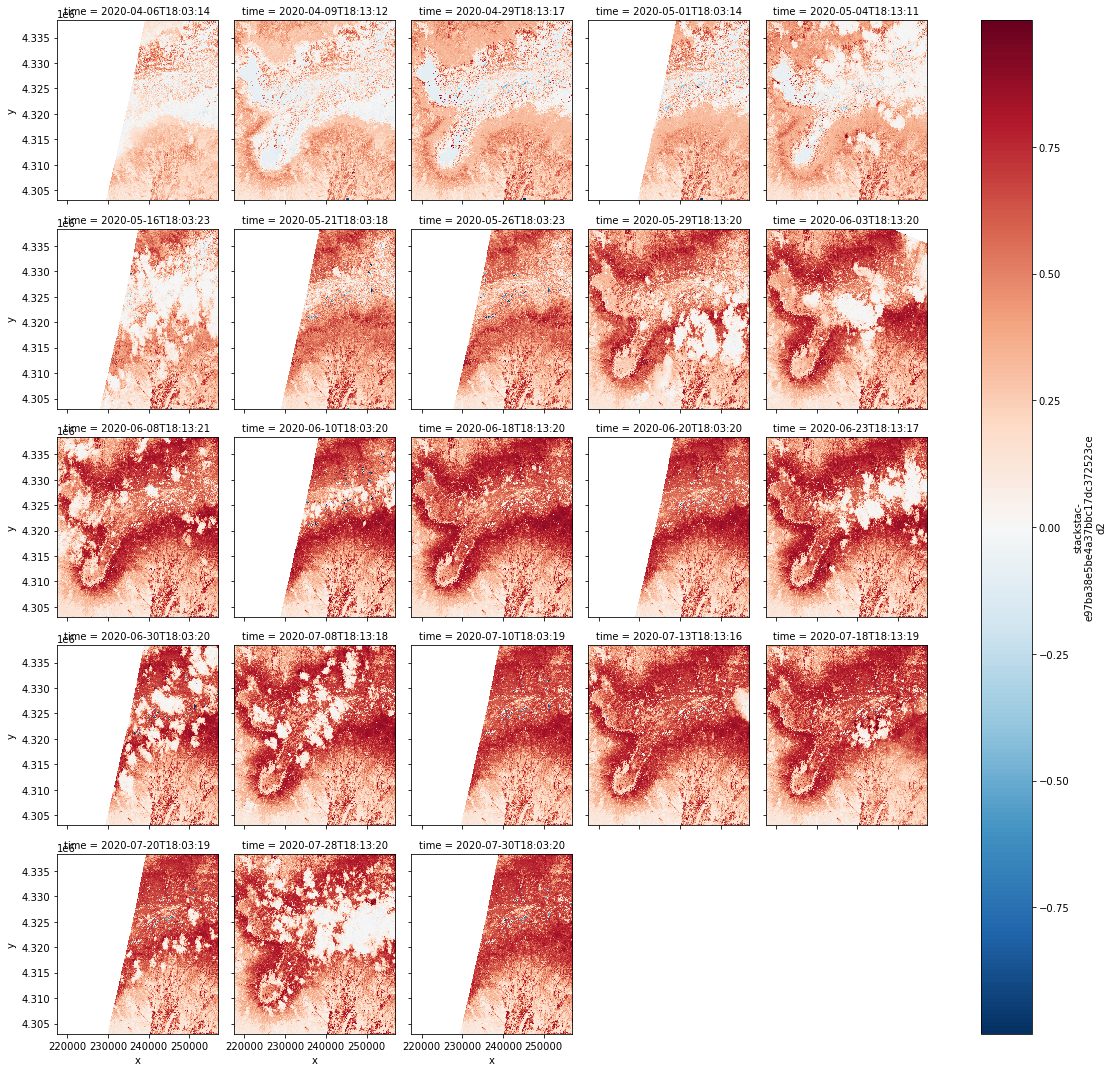

In [106]:
frames_ndvi.plot.imshow(col="time", col_wrap = 5, robust=False);

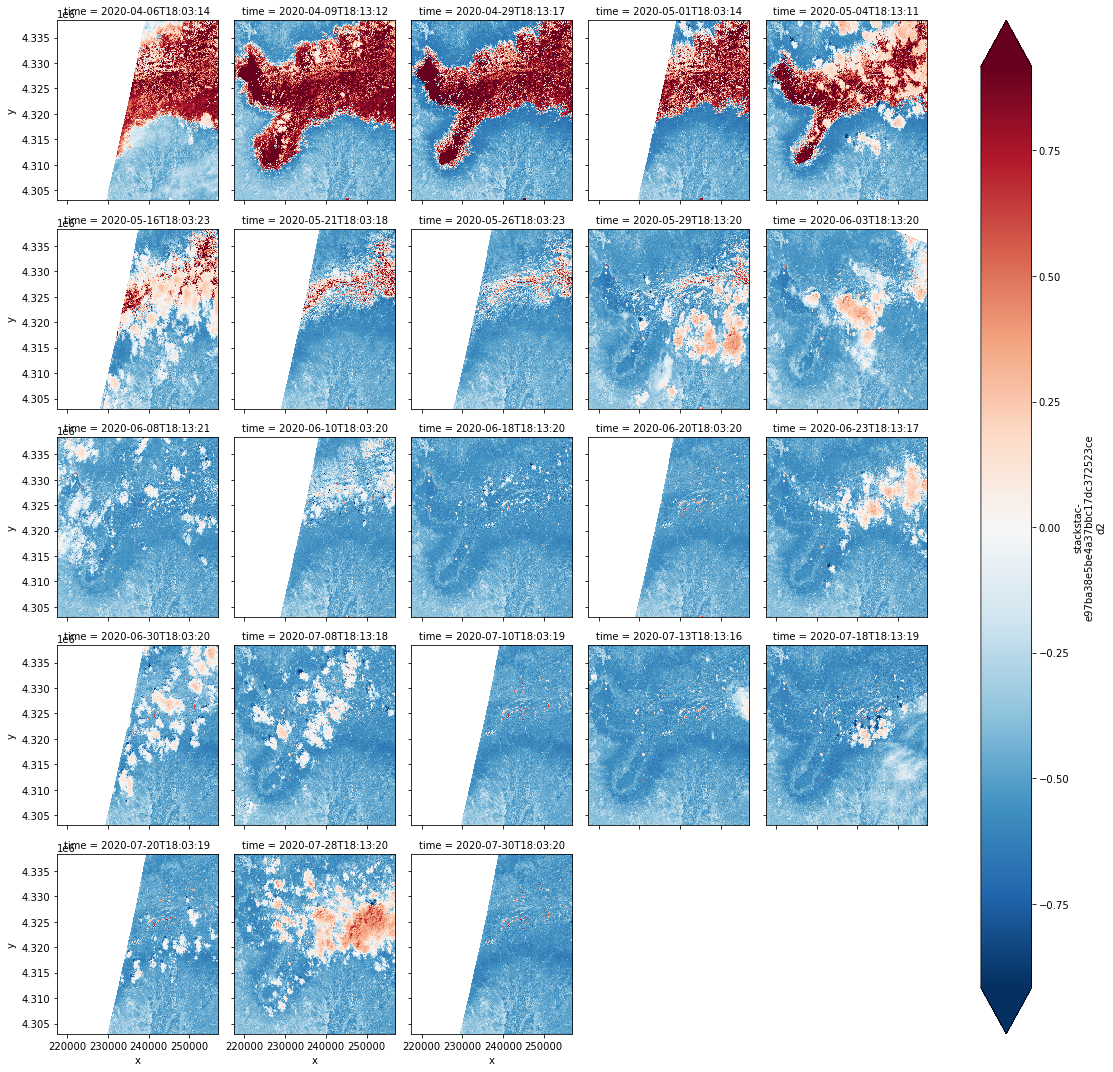

In [107]:
frames_ndsi.plot.imshow(col="time", col_wrap = 5, robust=True,aspect=1);

NameError: name 'frames_nis' is not defined

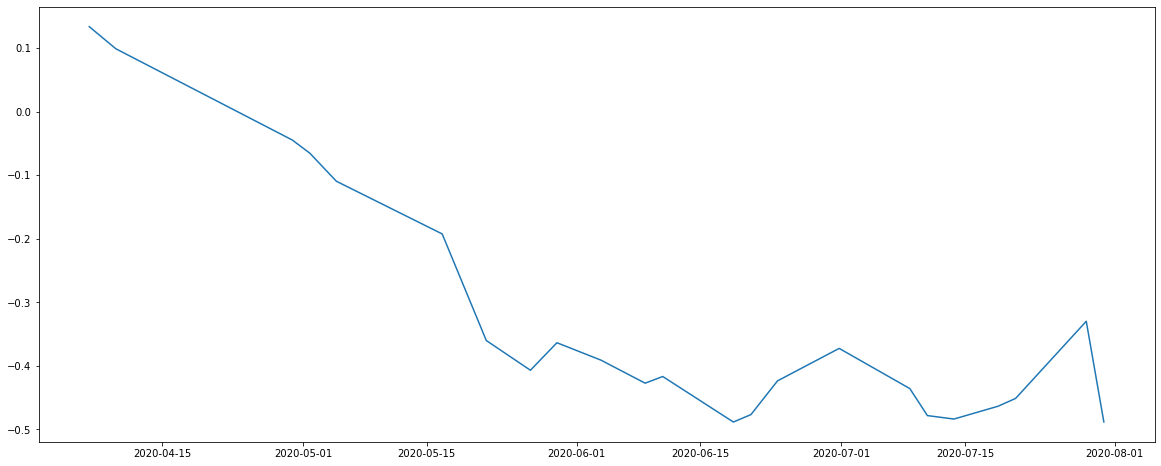

In [53]:
# look for local min for melt timings
f,ax = plt.subplots(figsize=(20,8))

ax.plot(frames_ndsi.time,frames_ndsi.mean(dim=['x','y']),label='Entire Scene')
ax.plot(frames_nis.time,frames_nis.mean(dim=['x','y']),label='Nisqually Glacier')
ax.plot(frames_emm.time,frames_emm.mean(dim=['x','y']),label='Emmons Glacier')
ax.plot(frames_car.time,frames_car.mean(dim=['x','y']),label='Carbon Glacier')
ax.plot(frames_tah.time,frames_tah.mean(dim=['x','y']),label='Tahoma Glacier')
ax.plot(frames_named.time,frames_named.mean(dim=['x','y']),label='All Glaciers')

#ax2=ax.twinx()
#snotel_df.plot.scatter(x='date_time_utc',y='value',ax=ax2,c='r',alpha=0.4,label='SWE')

ax.set_xlim([time_slice.start,time_slice.stop])
ax.legend()
#ax2.legend(loc='upper right')
#ax2.grid(False)
#ax2.set_ylabel('Snow Water Equivalent [cm]')
ax.set_ylabel('NDSI')

ax.set_title(f'Sentinel2 NDSI Values \nfor ({time_slice.start}, {time_slice.stop})')

In [ ]:
if shapefile_clip == True:
    rainier_glaciers = rainier_glaciers.to_crs(stack.crs)
    frames_nis = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Nisqually Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False)
    frames_emm = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Emmons Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False) 
    frames_car = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Carbon Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False) 
    frames_tah = frames_ndsi.rio.clip(rainier_glaciers[rainier_glaciers['Name'] == 'Tahoma Glacier WA'].geometry,rainier_glaciers.crs,drop=True,invert=False) 
    frames_named = frames_ndsi.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False)

In [ ]:
# look for local min for melt timings
f,ax = plt.subplots(figsize=(20,8))

ax.plot(frames_ndsi.time,frames_ndsi.mean(dim=['x','y']),label='Entire Scene')
ax.plot(frames_nis.time,frames_nis.mean(dim=['x','y']),label='Nisqually Glacier')
ax.plot(frames_emm.time,frames_emm.mean(dim=['x','y']),label='Emmons Glacier')
ax.plot(frames_car.time,frames_car.mean(dim=['x','y']),label='Carbon Glacier')
ax.plot(frames_tah.time,frames_tah.mean(dim=['x','y']),label='Tahoma Glacier')
ax.plot(frames_named.time,frames_named.mean(dim=['x','y']),label='All Glaciers')

#ax2=ax.twinx()
#snotel_df.plot.scatter(x='date_time_utc',y='value',ax=ax2,c='r',alpha=0.4,label='SWE')

ax.set_xlim([time_slice.start,time_slice.stop])
ax.legend()
#ax2.legend(loc='upper right')
#ax2.grid(False)
#ax2.set_ylabel('Snow Water Equivalent [cm]')
ax.set_ylabel('NDSI')

ax.set_title(f'Sentinel2 NDSI Values \nfor ({time_slice.start}, {time_slice.stop})')

In [ ]:
#%%time
#vis = lowcloud.sel(band='visual')
#vis = vis.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
#vis.compute()
#vis.plot.imshow(col="time", col_wrap = 5, robust=True);

In [ ]:
# train all S2 bands on SAR backscatter data? 
# rate at which NDSI dips proportional to debris?

In [ ]:
#frames_rgb = None
#frames_ndvi = None
#frames_ndsi = None

#frames_nis = None
#frames_emm = None
#frames_car = None
#frames_tah = None
#frames_named = None

In [ ]:
#frames_rgb = None

In [ ]:
#%%time
#scenes_all_bands = lowcloud.sel(band=['B02','B03','B04','B05','B06','B07','B08','B09','B11','B12']).sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
#frames_all_bands = scenes_all_bands.compute()

In [ ]:
#f,ax = plt.subplots(figsize=(20,8))
#frames_all_bands = frames_all_bands.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False)
#ax.plot(frames_all_bands.time,frames_all_bands.mean(dim=['x','y']),label='Entire Scene')

#ax.set_xlim([time_slice.start,time_slice.stop])
#ax.legend()
#ax2.legend(loc='upper right')
#ax2.grid(False)
#ax2.set_ylabel('Snow Water Equivalent [cm]')
#ax.set_ylabel('Reflectance')

#ax.set_title(f'Sentinel2 All Band \nfor ({time_slice.start}, {time_slice.stop})')

In [ ]:
frames_rgb